# Cleaning and Building Data Set of Mountain Biking Trails and Parks

Before any exploration or model training can be performed, the areas allowing mountain biking and parks without MTB will need to be created.

# Setup

In [1]:
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import geopandas as gpd
from shapely import ops # General Shape Operations
from shapely.prepared import prep # Filter Trails by state

# File path for project data
FILE_PATH = "<LOCAL PATH>"
# File path for NC counties
NC_COUNTIES = FILE_PATH + "NC_counties/North_Carolina_State_and_County_Boundary_Polygons.shp"
# File Path for NC Parks
NC_PARKS = FILE_PATH + "NC_Parks/"
# File path for OSM Data
OSM_DATA = FILE_PATH + "OSM_Data/"
# Output
OUTPUT = FILE_PATH + "Output/"
# Columns to pull from OSM data
OSM_COLS = ["name", "id", "geometry"]

# NC Map Fig size
NC_MAP_SIZE = (15,10)
# Size for a single plot
PLOT_1 = (10, 7)
# Sizes for others plots
PX = 7
PY = 5
# Park Color
PARK_COLOR = 'mediumseagreen'
# Random Seed
SEED = 415

## Functions

In [2]:
def get_OSM_trails(cols, land_use, crs = None, data_path = OSM_DATA):
    """Used to read in a directory containg geojson files and return a single data frame.
    This is particularly helpful if multiple queries from OpenStreetMap are needed to get
    all of the desired points.
    
    ## Parameters
    - cols: Columns from the geojson file to retain
    - land_use: Tag denoting if an area is used for MTB or not
    - crs: The coordinate refernce system to use. If specifed the imported data is 
    converted to the denoted crs
    - data_path: Path to read files from
    
    ## Returns
    A single dataframe composed all geojson files in the directory"""
    
    dfs = []

    for _,fp in enumerate(glob(data_path + "*")):

        fp_name = fp.split(".")

        # Validate file path
        if len(fp_name) < 2 or fp_name[-1] != "geojson":
            print(f"{fp}: invalid, skipping")
            continue
        
        trails = gpd.read_file(fp)[cols]
        # If a crs is provided convert files that are read in
        if crs:
            trails = trails.to_crs(crs)

        trails["land_use"] = land_use
        dfs.append(trails)

    return pd.concat(dfs)

def get_geo_dist(poly, geod):
    """Compute distance between xmin,ymin and xmax, ymax in meters
    
    ## Parameters
    - poly: shapely polygon to determine the length of the diagonal
    - geod: pyproj projection used to calculate distance"""
    lats = [poly.bounds[0], poly.bounds[2]]
    lons = [poly.bounds[1], poly.bounds[3]]

    return geod.line_length(lons, lats)

## Data

In [3]:
nc = gpd.read_file(NC_COUNTIES, engine = "pyogrio")
# Read parks straight from zip file
parks = gpd.read_file("zip://" + NC_PARKS + "North_Carolina_Natural_Heritage_Program_Managed_Areas.zip", engine = "pyogrio")
# All of the data will be projected to the NC Counties CRS
parks = parks.to_crs(nc.crs)
osm_trails = get_OSM_trails(cols = OSM_COLS, land_use = "mtb", crs = nc.crs)

G:/UNCG_Capstone/OSM_Data\Mt_Mitchell_Query: invalid, skipping
G:/UNCG_Capstone/OSM_Data\README.md: invalid, skipping


### NC Counties

`nc` is a set of vector shapes for each NC county.

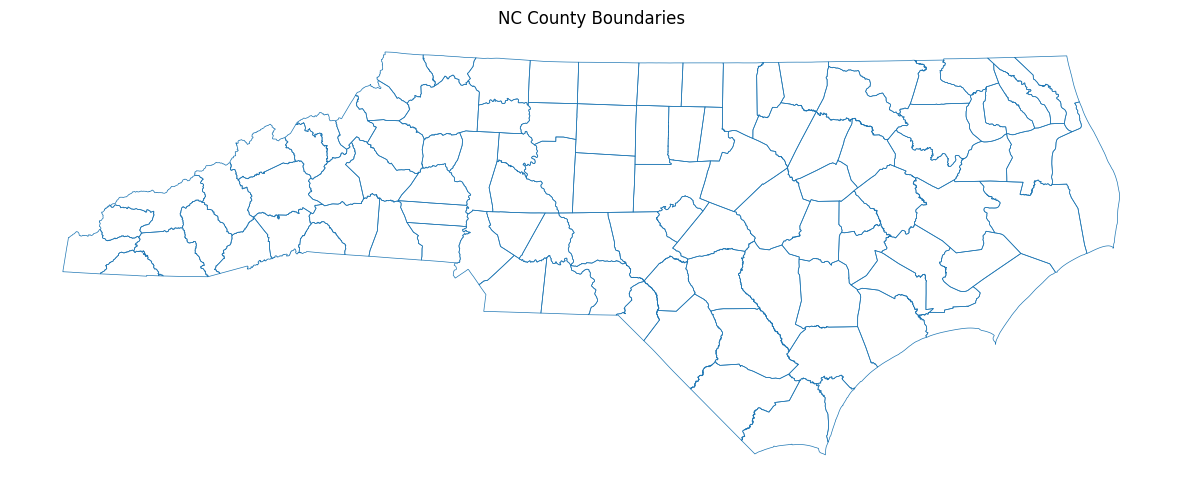

In [4]:
fig, ax  = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
ax.set_title("NC County Boundaries")
plt.axis('off');

### OSM Trails

`osm_trails` is composed of individual trails all over NC. These will need to be combined combined for analysis and modeling.

In [5]:
osm_trails.head()

,name,id,geometry,land_use
0,Virginia Highlands Horse Trail,way/15473901,"LINESTRING (1289769.217 1099284.494, 1289814.4...",mtb
1,Yancey Ridge Trail (259),way/16401409,"LINESTRING (1175722.594 851100.436, 1175736.09...",mtb
2,Rainbow Road,way/16419052,"LINESTRING (1019287.205 703660.909, 1019297.66...",mtb
3,Rainbow Road,way/16430359,"LINESTRING (1020151.017 704958.926, 1020121.67...",mtb
4,None,way/16779126,"LINESTRING (881111.155 576406.526, 881008.981 ...",mtb


In [6]:
print(f"OSM individual trails: {osm_trails.shape[0]}")

OSM individual trails: 1578


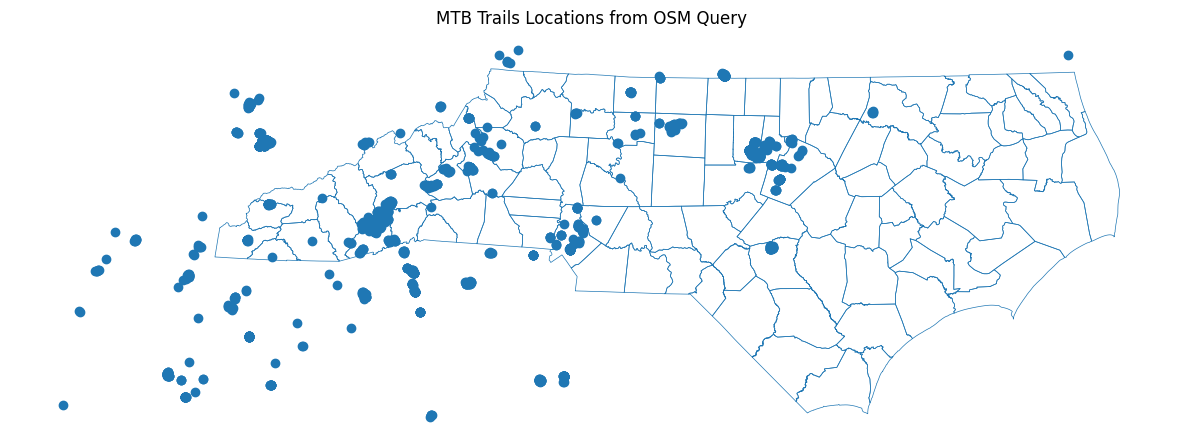

In [7]:
color_dict = { "MTB" : 'royalblue', "No MTB" : 'orange' }

fig, ax = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
(osm_trails.assign(geometry = osm_trails.centroid)
    .plot(ax = ax))
ax.set_title("MTB Trails Locations from OSM Query")
plt.axis('off');

The query from OSM uses a bounding box to limit results to a given area, hence the locations outside of NC. These will be need to be removed.

### NC Parks

The features of interest are:
- `MA_NAME`: name of the park
- `OWNER`: owner of the park
- `OWNER_TYPE`: type of owner
    - federal, state, local, private
- `Shape_Area`: geodetic area of the park
- `geometry`: vector outline of the park

In [8]:
parks_cols = ["MA_NAME", "MA_ID", "OWNER", "OWNER_TYPE", "CATEGORY", "Shape_Area", "geometry"]
parks[["MA_NAME", "OWNER", "OWNER_TYPE", "Shape_Area", "geometry"]].head()

,MA_NAME,OWNER,OWNER_TYPE,Shape_Area,geometry
0,4-H Environmental Education Conference Center,North Carolina State University,State,2.935948e+06,"MULTIPOLYGON (((2784026.942 807815.773, 278421..."
1,Alamance Battleground State Historic Site,"NC DNCR, Division of State Historic Sites and ...",State,6.204743e+05,"MULTIPOLYGON (((1846824.945 820938.253, 184570..."
2,Alamance County - Cane Creek Mountains Natural...,Alamance County,Local Government,2.257375e+06,"MULTIPOLYGON (((1872543.660 805045.207, 187298..."
3,Alamance County - Cedarock Park,Alamance County,Local Government,2.520504e+06,"POLYGON ((1870563.087 818507.156, 1870919.550 ..."
4,Alamance County - Great Alamance Creek Paddle ...,Alamance County,Local Government,1.945459e+04,"POLYGON ((1882969.427 828363.894, 1883018.279 ..."


Because, the entries do not include an assoicated county, that will need to assigned. This will become important when these shapes are used to mask out raster values later in the process.

# Cleaning OSM Trails

First any trails that are not located in NC will be excluded from the data set

<Axes: >

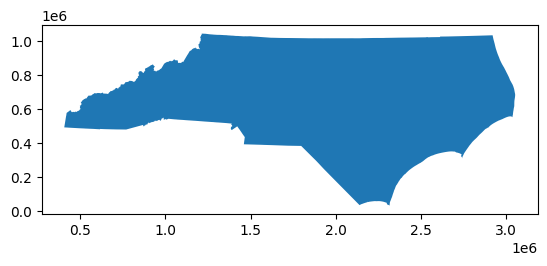

In [9]:
nc_boundry = gpd.GeoDataFrame(geometry = [nc.geometry.unary_union], crs = nc.crs)
nc_boundry.plot()

In [10]:
nc_boundry_prep = prep(nc_boundry.iloc[0,0])
mask = osm_trails.geometry.apply(lambda x: nc_boundry_prep.contains(x))

In [11]:
mask.value_counts()

True     938
False    640
Name: count, dtype: int64

640 trails do not fall in the boundary of NC.

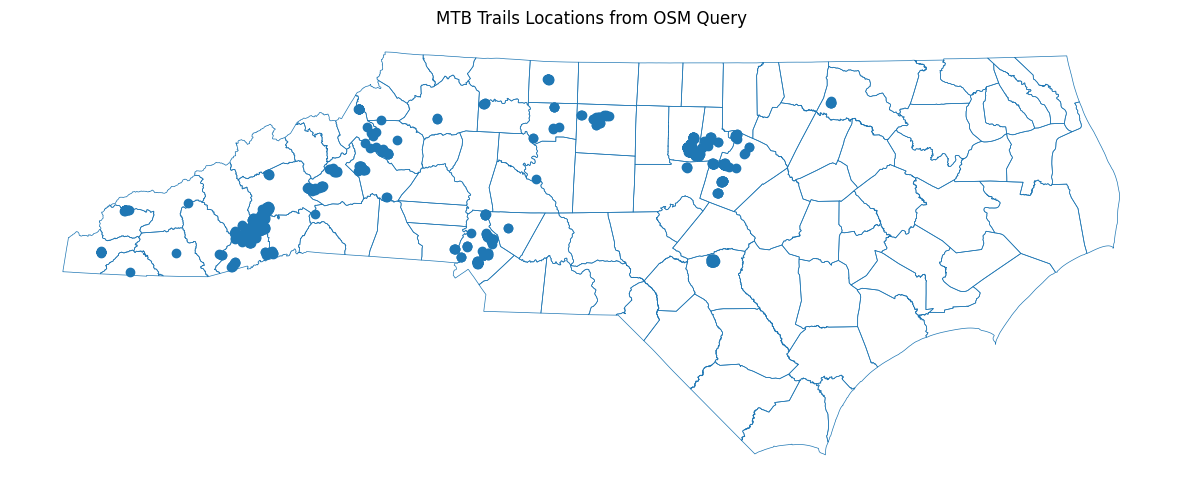

In [12]:
fig, ax = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
(osm_trails.assign(geometry = osm_trails.centroid)
    [mask]
    .plot(ax = ax))
ax.set_title("MTB Trails Locations from OSM Query")
plt.axis('off');

In [13]:
osm_trails = osm_trails.loc[mask, :]

Next duplicates will be checked for

In [14]:
osm_trails.duplicated(subset = ["id", "geometry"]).value_counts()

False    938
Name: count, dtype: int64

Doesn't look like there are any duplicates

## Joining Connected Trails

The trail segments do not contain metadata denoting which are connected. In order to use them to mask out raster values they will need to be joined into contiguous shapes. All of the individual trails are independent line strings. Below are the trails in Lake Crabtree County Park in Wake County

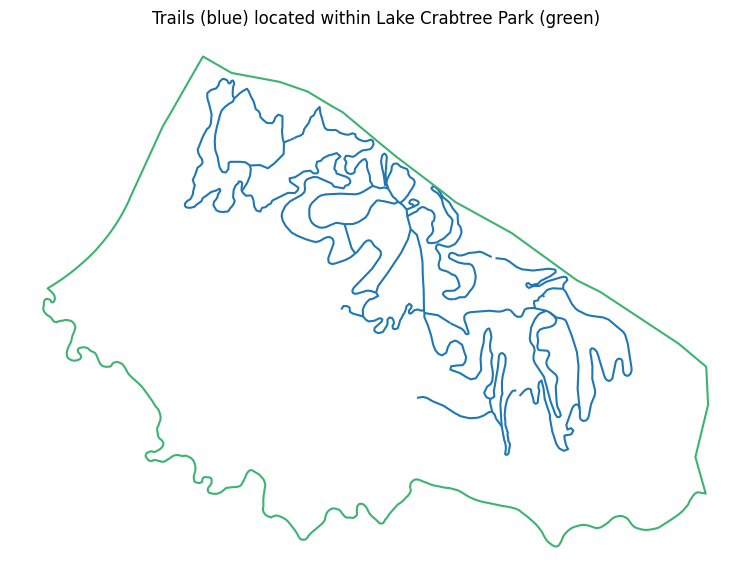

In [15]:
crabtree_park = parks[parks.MA_NAME.str.contains("Lake Crabtree")].iloc[0,-1]
mask = osm_trails.geometry.apply(lambda x: crabtree_park.contains(x))
fig, ax = plt.subplots( figsize = PLOT_1 )
osm_trails.loc[mask, "geometry"].plot(ax = ax)
parks[parks.MA_NAME.str.contains("Lake Crabtree")].boundary.plot(ax = ax, color = PARK_COLOR)
ax.set_title("Trails (blue) located within Lake Crabtree Park (green)")
plt.axis('off');

Using the information from the coordinate reference system (CRS) a buffer of 100 feet will be applied around each of the line segments and then any overlapping shapes will be joined into a single trail system.

In [16]:
osm_trails["geometry_buffer"] = osm_trails.geometry.apply(lambda x: x.buffer(100))
merged_trails = ops.unary_union(osm_trails.geometry_buffer)

The plot below gives an example what exactly the merging process looks like.

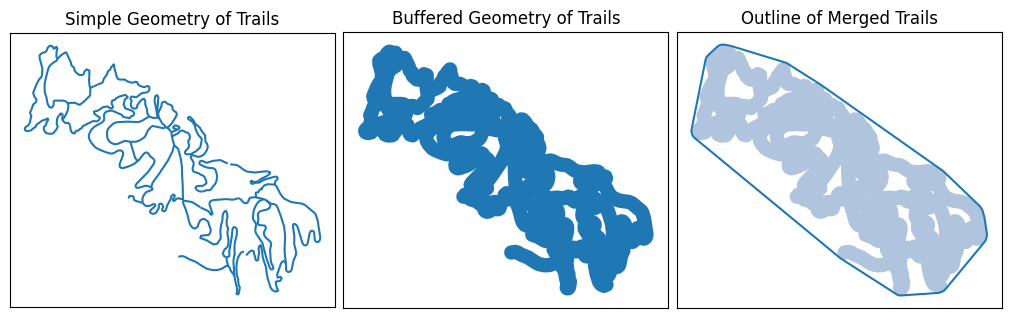

In [17]:
test_merge = ops.unary_union(osm_trails.loc[mask, "geometry_buffer"])

fig, ax = plt.subplots(ncols = 3, figsize = (10,5), constrained_layout = True)
for i in range(3):
    ax[i].set(yticklabels=[],xticklabels=[])
    ax[i].tick_params(left = False, bottom = False)

# Individual Trails
osm_trails.loc[mask, "geometry"].plot(ax = ax[0])
# parks.query('Park_Name == "Lake Crabtree County Park"').boundary.plot(ax = ax[0], color = 'green')
ax[0].set_title("Simple Geometry of Trails")
# Buffered Trails
osm_trails.loc[mask, "geometry_buffer"].plot(ax = ax[1])
# parks.query('Park_Name == "Lake Crabtree County Park"').boundary.plot(ax = ax[1], color = 'green')
ax[1].set_title("Buffered Geometry of Trails")
# Convex Hull to mask values
osm_trails.loc[mask, "geometry_buffer"].plot(ax = ax[2], color = 'lightsteelblue')
# parks.query('Park_Name == "Lake Crabtree County Park"').boundary.plot(ax = ax[2], color = 'green')
gpd.GeoSeries(test_merge).convex_hull.boundary.plot(ax = ax[2])
ax[2].set_title("Outline of Merged Trails");

A new GeoDataFrame will be created to hold all of the merged trail segments. The area will be computed using a geodetic calculation which will give an accurate measurement in **square meters**.

In [18]:
trails_df = gpd.GeoDataFrame(geometry = list(merged_trails.geoms), crs = nc.crs)
# Get the outline of each of the merged areas of trails
trails_df["outline"] = trails_df.geometry.convex_hull
geod = trails_df.crs.get_geod()
# Using the convex hull of each set of trails
trails_df["area"] = (trails_df.to_crs(trails_df.crs.geodetic_crs)
                        .geometry.apply(lambda x: abs(geod.geometry_area_perimeter(x.convex_hull)[0])))
trails_df = trails_df[["outline", "area", "geometry"]]
trails_df.head()

,outline,area,geometry
0,"POLYGON ((573816.873 491670.935, 573807.105 49...",6.739168e+05,"POLYGON ((573380.499 492431.189, 573398.839 49..."
1,"POLYGON ((827189.766 503455.791, 827179.954 50...",3.175570e+06,"POLYGON ((827242.869 503713.174, 827247.250 50..."
2,"POLYGON ((804142.197 533906.373, 802699.519 53...",4.483349e+05,"POLYGON ((801546.364 534318.863, 801537.754 53..."
3,"POLYGON ((796407.948 537176.131, 796398.150 53...",6.864802e+04,"POLYGON ((797115.912 538376.277, 797114.113 53..."
4,"POLYGON ((690537.120 540584.124, 690527.197 54...",2.680656e+04,"POLYGON ((690440.122 541294.984, 690448.538 54..."


There are likely fragments of trails that failed to merge these will be identified by examining the distribution area and applying a threshold based on the size of the merged areas.

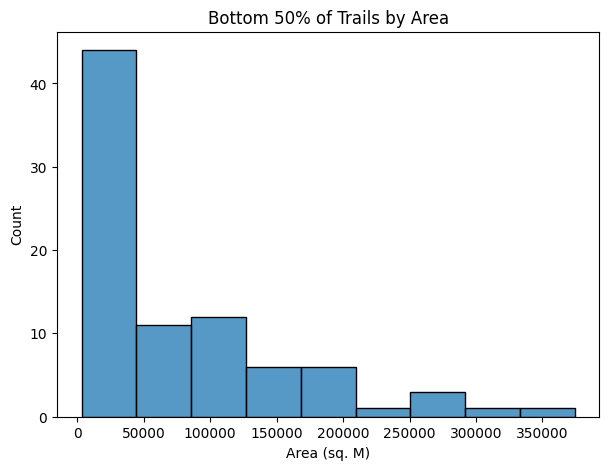

In [19]:
fig, ax = plt.subplots(figsize = (PX, PY))
sns.histplot(x = trails_df.loc[trails_df.area <= 1.2E6, "area"])
ax.set_title("Bottom 50% of Trails by Area");
ax.set_xlabel("Area (sq. M)");

Using Triangle MTB (https://www.trianglemtb.com/) as a source of truth there are 9 areas in Wake County that allow mountain biking. Based on the above plot, there is a sharp drop off above $2*10^5$ sq. meters.

In [20]:
wake = nc.query('County == "Wake"')["geometry"].iloc[0]
mask = trails_df.geometry.apply(lambda x: wake.contains(x))
print(f"All merged areas in Wake County: {trails_df[mask].shape[0]}")
print(f"Merged areas above threshold in Wake County: {trails_df[mask].query('area > 2E5').shape[0]}")

All merged areas in Wake County: 14
Merged areas above threshold in Wake County: 9


In [21]:
trails_df = trails_df.query('area > 2E5')

# Cleaning NC Parks

There are some duplicated values.

In [22]:
print(f"Rows: {parks.shape[0]}, Unique IDs: {parks.MA_ID.nunique()}")

Rows: 19220, Unique IDs: 19218


In [23]:
parks[parks.duplicated(subset = "MA_ID", keep = False)]

,OBJECTID,MA_ID,ACRES,MA_NAME,OWNER,OWNER_TYPE,CATEGORY,GIS_SRC,SRC_DATE,GAP_STATUS,SYMBOLOGY,LABEL,DATA_DATE,Shape_Leng,Shape_Area,geometry
7746,7747,13451,540.39,Historic Yates Mill Pond County Park,Wake County,Local Government,Other,YMP.shp,2020-07-06,3 - managed for multiple uses - subject to ext...,Other Protection,Yates Mill,2024-04-01,16657.927229,3.326217e+06,"POLYGON ((2088788.241 719108.175, 2088904.612 ..."
7747,7748,13451,540.39,Historic Yates Mill Pond County Park,State of North Carolina,State,Other,YMP.shp,2020-07-06,3 - managed for multiple uses - subject to ext...,Other Protection,Yates Mill,2024-04-01,16657.927229,3.326217e+06,"POLYGON ((2088788.241 719108.175, 2088904.612 ..."
19115,19116,638,45.21,Salisbury Nature Study Registered Heritage Area,Salisbury-Rowan Schools,Local Government,Other,Salisbury_Nature_Study_RHA_2020_for_MAREA.shp,2020-07-29,3 - managed for multiple uses - subject to ext...,Registered Heritage Area,Salisbury Nature Study RHA,2024-04-01,3214.522655,2.779801e+05,"POLYGON ((1560524.468 710206.519, 1560560.098 ..."
19116,19117,638,45.21,Salisbury Nature Study Registered Heritage Area,"NC DNCR, Natural Heritage Program",State,Other,Salisbury_Nature_Study_RHA_2020_for_MAREA.shp,2020-07-29,3 - managed for multiple uses - subject to ext...,Registered Heritage Area,Salisbury Nature Study RHA,2024-04-01,3214.522655,2.779801e+05,"POLYGON ((1560524.468 710206.519, 1560560.098 ..."


They look like they just have different `OBJECTID` fields. Only the first occurrence will be retained.

In [24]:
parks.drop(index = parks[parks.duplicated(subset = "MA_ID")].index, inplace = True)

Counties need to be assigned to each of the parks. This will be accomplished with a spatial join.

In [25]:
parks_county = gpd.sjoin(left_df = parks[parks_cols], # These are the buffered and combined polygons
          right_df = nc[["County", "geometry"]], 
          how = 'left', predicate = 'intersects')

In [26]:
parks_county.MA_ID.value_counts().head()

MA_ID
2005     20
16504    18
23098    18
23622    17
444      17
Name: count, dtype: int64

In [27]:
(parks_county.MA_ID.value_counts() >= 2).value_counts()

count
False    18399
True       819
Name: count, dtype: int64

In this data set there are a few areas that are actually pieces of land located all over NC, hence the large number of counties. The focus of this project is to train the models on contiguous areas, so these will be excluded.

In [28]:
# Get index of areas that are only in one county
mask = pd.DataFrame(parks_county.MA_ID.value_counts()).query('count == 1').index
parks_county.set_index("MA_ID").loc[mask, :].reset_index().tail(8)

,MA_ID,MA_NAME,OWNER,OWNER_TYPE,CATEGORY,Shape_Area,geometry,index_right,County
18391,21965,Town of Minnesott Open Space,Town of Minnesott,Local Government,Fee,3259.957034,"POLYGON ((2656498.939 452954.256, 2656279.966 ...",39.0,Pamlico
18392,13073,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,4847.970571,"POLYGON ((1500579.969 522316.705, 1500516.452 ...",40.0,Mecklenburg
18393,13071,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,102084.088698,"MULTIPOLYGON (((1503544.694 522924.151, 150348...",40.0,Mecklenburg
18394,13091,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,140186.093915,"POLYGON ((1505359.421 527375.422, 1504405.650 ...",40.0,Mecklenburg
18395,13042,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,6534.886016,"POLYGON ((1490685.369 523291.309, 1490541.078 ...",40.0,Mecklenburg
18396,13039,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,428886.112277,"POLYGON ((1512170.365 524359.516, 1512240.214 ...",40.0,Mecklenburg
18397,13083,Town of Mint Hill Open Space,Town of Mint Hill,Local Government,Fee,14356.721971,"POLYGON ((1501300.571 522216.705, 1501290.597 ...",40.0,Mecklenburg
18398,20177,NC Hazard Mitigation Buyout Property - Lenoir ...,"NC DPS, Division of Emergency Management",State,Other,10420.939815,"POLYGON ((2449883.572 559853.611, 2449809.632 ...",23.0,Lenoir


Note that some of these areas have generic names, but are distinct areas. 

In [29]:
parks_county = parks_county.set_index("MA_ID").loc[mask, :].reset_index()
parks_county.Shape_Area.describe()

count    1.839900e+04
mean     8.426671e+05
std      8.606560e+06
min      7.730620e-05
25%      6.142381e+03
50%      4.582214e+04
75%      2.558561e+05
max      7.580738e+08
Name: Shape_Area, dtype: float64

Managed areas are divided into three categories: Fee, Easement, Other. 

In [30]:
parks[parks.MA_NAME.str.contains("Hazard")].head(3)

,OBJECTID,MA_ID,ACRES,MA_NAME,OWNER,OWNER_TYPE,CATEGORY,GIS_SRC,SRC_DATE,GAP_STATUS,SYMBOLOGY,LABEL,DATA_DATE,Shape_Leng,Shape_Area,geometry
7867,7868,17257,4.52,NC Hazard Mitigation Buyout Property - Alamanc...,"NC DPS, Division of Emergency Management",State,Other,MitigatedProperties_AcquiredProperties.gdb,2021-07-08,3 - managed for multiple uses - subject to ext...,Other Protection,NC HM Buyout Prop,2024-04-01,845.795819,28035.516856,"POLYGON ((1881611.951 826263.410, 1881592.209 ..."
7868,7869,17258,0.93,NC Hazard Mitigation Buyout Property - Alamanc...,"NC DPS, Division of Emergency Management",State,Other,MitigatedProperties_AcquiredProperties.gdb,2021-07-08,3 - managed for multiple uses - subject to ext...,Other Protection,NC HM Buyout Prop,2024-04-01,381.335450,5765.632250,"POLYGON ((1886773.041 826300.464, 1886700.165 ..."
7869,7870,19371,0.56,NC Hazard Mitigation Buyout Property - Avery C...,"NC DPS, Division of Emergency Management",State,Other,MitigatedProperties_AcquiredProperties.gdb,2021-07-08,3 - managed for multiple uses - subject to ext...,Other Protection,NC HM Buyout Prop,2024-04-01,366.925244,3481.880888,"POLYGON ((1099314.968 862400.520, 1099334.489 ..."


In [31]:
print(f"Hazard Mitigation Properties: {parks_county[parks_county.MA_NAME.str.contains('Hazard')].shape[0]}")

Hazard Mitigation Properties: 3562


In [32]:
print(f"Other Category Properties: {parks_county[parks_county.CATEGORY == 'Other'].shape[0]}")

Other Category Properties: 5589


There are many areas of not needed areas in the `Other` category. The `Other` category will be excluded.

In [33]:
parks_county = parks_county.query('CATEGORY != "Other"')

## Remove Parks That Allow Mountain Biking

A spatial join will be used to find what parks overlap with areas that allow mountain biking

In [34]:
parks_county["park_row"] = np.arange(0, parks_county.shape[0]).astype(int)
trails_df["trail_row"] = np.arange(0, trails_df.shape[0]).astype(int)
join = gpd.sjoin(left_df = trails_df[["trail_row", "geometry"]], 
                 right_df = parks_county[["park_row", "geometry"]], 
                 how = 'left', 
                 predicate = 'intersects')
parks_down = parks_county[~parks_county.park_row.isin(join.park_row.dropna())]

In [35]:
print(f"All Parks: {parks_county.shape[0]}")
print(f"Parks Excluding MTB: {parks_down.shape[0]}")

All Parks: 12810
Parks Excluding MTB: 12761


## Excluding Small Parks

In [36]:
parks_county.Shape_Area.describe()

count    1.281000e+04
mean     8.404739e+05
std      9.429447e+06
min      7.730620e-05
25%      1.671707e+04
50%      7.043023e+04
75%      2.863686e+05
max      7.580738e+08
Name: Shape_Area, dtype: float64

Some of the park areas are incredibly small. The minimum $7*10^{-5}$ is either an error or an incredibly small area. These places will be excluded. 15 equally spaced intervals will be used later to calculate a value called the semivariance. With that number **15** in mind:
- each value in the topographic data is spaced 20ft apart.
- a diagonal line of at least 620 ft (189 meters) should mostly ensure that the appropriate number of lagged distances are possible

First the diagonal length of the bounding box of each park will be calculated

In [37]:
parks_county["line_length"] = parks_county.to_crs(parks_county.crs.geodetic_crs).geometry.apply(lambda x: get_geo_dist(x, geod))

Next the threshold of 189 meters will be applied

In [38]:
parks_down = parks_county.query('line_length > 189')
parks_down["Shape_Area"].describe()

count    9.784000e+03
mean     1.097500e+06
std      1.077669e+07
min      1.285586e+03
25%      4.728943e+04
50%      1.327442e+05
75%      4.290110e+05
max      7.580738e+08
Name: Shape_Area, dtype: float64

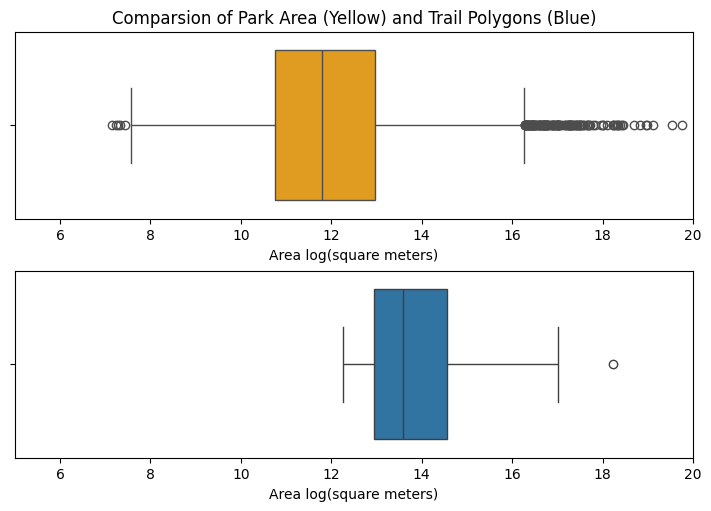

In [39]:
fig, ax = plt.subplots(nrows = 2, figsize = (PX, PY), constrained_layout = True)
sns.boxplot(x = np.log(parks_down.Shape_Area), ax = ax[0], color = "orange")
ax[0].set_title("Comparsion of Park Area (Yellow) and Trail Polygons (Blue)");
ax[0].set_xlim(xmin = 5, xmax = 20)
ax[0].set_xlabel("Area log(square meters)")
sns.boxplot(x = np.log(trails_df["area"]), ax = ax[1])
ax[1].set_xlabel("Area log(square meters)")
ax[1].set_xlim(xmin = 5, xmax = 20);

Overall the mtb trails look like they skew a little higher, but there is a lot of overlap as well.

# Resample Data

Due to the massive class imbalance between the number of areas without mountain biking and those with, the areas without mountain biking will be downsampled. Later, after several computationally heavy steps are completed, the areas with mountain biking will be upsampled.

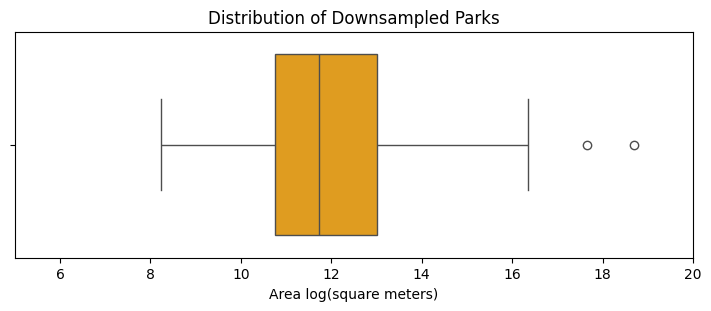

In [40]:
fig, ax = plt.subplots(figsize = (PX, PY - 2), constrained_layout = True)
sns.boxplot(x = np.log(parks_down.sample(n = 300, replace = False, random_state = SEED).Shape_Area), color = "orange", ax = ax)
ax.set_xlim(xmin = 5, xmax = 20)
ax.set_title("Distribution of Downsampled Parks")
ax.set_xlabel("Area log(square meters)");

Overall the sample distribution looks pretty similar to the total distribution.

In [41]:
parks_down.sample(n = 300, replace = False, random_state = SEED).County.value_counts().head(10)

County
Wake           32
Mecklenburg    13
Guilford        9
Pitt            9
Northampton     8
Halifax         7
Brunswick       7
Orange          7
Nash            7
Buncombe        7
Name: count, dtype: int64

In [42]:
parks_down = parks_down.sample(n = 300, replace = False, random_state = SEED)

# Export Datasets

## Exporting MTB Trails

In [43]:
trails_df.drop(columns = "geometry", inplace = True)
trails_df.rename(columns = {"outline" : "geometry"}, inplace = True)
trails_df.head()

,geometry,area,trail_row
0,"POLYGON ((573816.873 491670.935, 573807.105 49...",6.739168e+05,0
1,"POLYGON ((827189.766 503455.791, 827179.954 50...",3.175570e+06,1
2,"POLYGON ((804142.197 533906.373, 802699.519 53...",4.483349e+05,2
5,"POLYGON ((502163.436 541197.184, 502153.625 54...",2.175227e+06,3
6,"POLYGON ((874128.357 564348.367, 874118.580 56...",3.743272e+05,4


In [44]:
trails_df.to_file(OUTPUT + "Cleaned_Data/trails.shp")

In [45]:
trails_df.area.describe()

count    9.600000e+01
mean     2.920715e+07
std      9.621254e+07
min      2.245386e+06
25%      4.468830e+06
50%      8.628884e+06
75%      2.284039e+07
max      8.967430e+08
dtype: float64

## Exporting Non-MTB Parks

In [301]:
parks_down.drop(columns = ["line_length", "index_right"], inplace = True)
parks_down.head()

,MA_ID,MA_NAME,OWNER,OWNER_TYPE,CATEGORY,Shape_Area,geometry,County,park_row
7456,6726,Conservation Reserve Enhancement Program Easement,"NC Department of Agriculture, Division of Soil...",State,Easement,43422.652300,"POLYGON ((2449610.518 890227.747, 2449812.880 ...",Halifax,3919
6507,13849,Triangle Land Conservancy Easement,Triangle Land Conservancy,Private,Easement,244317.942081,"POLYGON ((1971143.299 822961.576, 1971143.824 ...",Orange,2971
13262,5589,City of Greensboro - OHenry Oaks Park,City of Greensboro,Local Government,Fee,44417.452780,"MULTIPOLYGON (((1772255.508 861472.883, 177219...",Guilford,9723
6169,23315,Three Rivers Land Trust Easement,Three Rivers Land Trust,Private,Easement,790412.216182,"POLYGON ((1505885.175 700247.058, 1505999.479 ...",Rowan,2633
7744,8038,Conservation Reserve Enhancement Program Easement,"NC Department of Agriculture, Division of Soil...",State,Easement,97698.825963,"POLYGON ((2578894.544 928521.896, 2578942.937 ...",Hertford,4207


In [302]:
parks_down.to_file(OUTPUT + "Cleaned_Data/parks.shp")

The whole parks set with county mapping will also be exported for exploration.

In [46]:
parks_county.drop(columns = ["line_length", "index_right"]).to_file(OUTPUT + "Cleaned_Data/parks_all.shp")